In [67]:
import re
import collections
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from keras import models
from keras import layers
from keras import regularizers
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer

In [5]:
data = pd.read_csv('Data/data.csv')
data.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [47]:
def remove_stopwords(input_text):
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 
    
def remove_elements(input_text):
    text = re.sub(r'@\w+', '', input_text) # Removes tweet mentiones
    text = re.sub(r"\S*https?:\S*", "", text) # Removes URL's
    return text
       
data['Sentence'] = data['Sentence'].apply(remove_stopwords).apply(remove_elements)
data.head()

,Sentence,Sentiment
0,The GeoSolutions technology leverage Benefon '...,positive
1,"$ESI lows, $1.50 $2.50 BK real possibility",negative
2,For last quarter 2010 Componenta 's net sales ...,positive
3,According Finnish-Russian Chamber Commerce maj...,neutral
4,The Swedish buyout firm sold remaining 22.4 pe...,neutral


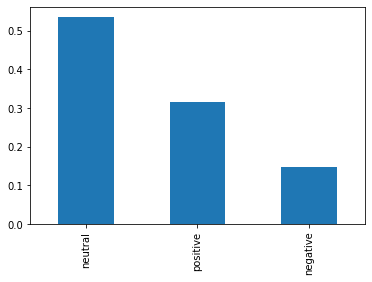

In [48]:
data['Sentiment'].value_counts(normalize=True).plot(kind='bar')
# There is definately a skew here, lets make sure to stratify the train test split to ensure.

Gameplan for this model:
    - N-Grams
    - Keras model
    - Spacy model
    - Voting model

In [22]:
# General Settings
NB_WORDS = 10000
VAL_SIZE = 1000
NB_START_EPOCHS = 20
BATCH_SIZE = 512

In [49]:
X_train, X_test, y_train, y_test = train_test_split(
    data['Sentence'],
    data['Sentiment'],
    test_size = 0.3,
    stratify = data['Sentiment'],
    random_state = 42
)

print(f'We have {X_train.shape[0]} training sample and {X_test.shape[0]} testing samples.')

We have 4089 training sample and 1753 testing samples.


In [50]:
tk = Tokenizer(num_words = NB_WORDS,
    filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower = True,
    split = " "
)

tk.fit_on_texts(X_train)

print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))

Fitted tokenizer on 4089 documents
10000 words in dictionary
Top 5 most common words are: [('the', 922), ('eur', 863), ("'s", 664), ('company', 541), ('mn', 497)]


In [51]:
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

In [52]:
X_train[0:3]

26            Costco: Premier Retail Dividend Play  $COST
5197    The Diameter Protocol developed according stan...
4070    Glaston 's share GLA1V listed NASDAQ OMX Helsi...
Name: Sentence, dtype: object

In [53]:
tk.sequences_to_texts(X_train_seq[0:3])

['costco premier retail dividend play cost',
 'the diameter protocol developed according standards ietf rfc 3588 ietf rfc 3539',
 "glaston 's share gla1v listed nasdaq omx helsinki mid cap list"]

In [68]:
def one_hot_seq(seqs, nb_features = NB_WORDS):
    ohs = np.zeros((len(seqs), nb_features))
    for i, s in enumerate(seqs):
        ohs[i, s] = 1.
    return ohs

# This loses order, which is fine for now.
X_train_oh = one_hot_seq(X_train_seq)
X_test_oh = one_hot_seq(X_test_seq)

In [71]:
X_train_oh.shape

(4089, 10000)

In [72]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

print('"{}" is converted into {}'.format(y_train[0], y_train_le[0]))
print('"{}" is converted into {}'.format(y_train_le[0], y_train_oh[0]))

"positive" is converted into 2
"2" is converted into [0. 0. 1.]
